# Data Preprocessing

In [1]:
import requests
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [32]:
# Export Clean Artists Dataframe
preprocessed_df = pd.read_csv('preprocessed_df.csv', index_col=0)

In [33]:
preprocessed_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature,popularity,release_date,explicit,release_year,virality
0,0.109892,-0.399148,7,0.447035,1,0.0353,-0.626147,-0.225815,-0.612151,-0.688519,0.000427,-0.450347,3,-0.787262,1983-01-01,0,1983.0,0
1,0.312524,0.961265,9,0.782909,1,0.1450,0.040012,-0.225815,0.775918,0.880122,0.518389,-1.035873,4,-0.787262,1997-06-04,0,1997.0,0
2,1.162273,-0.833323,9,-1.570594,1,0.0329,0.900743,-0.026841,-0.660016,-0.535065,-0.658211,-0.084343,4,-0.787262,2009-01-01,0,2009.0,0
3,-0.164642,0.869606,0,-0.219940,1,0.0410,1.035954,-0.225252,0.351803,1.775271,-1.488966,0.146881,4,-0.787262,2018-12-18,0,2018.0,0
4,-2.380525,-0.698246,3,-0.788480,1,0.0377,1.045847,-0.225815,-0.647292,-1.822800,-1.185859,-0.400683,3,-0.787262,2014-03-07,0,2014.0,0


In [34]:
preprocessed_df.shape

(2266, 18)

In [4]:
# Extract desired features
features = ['danceability', 'duration_s', 'explicit', 
            'mode', 'valence', 'energy', 'tempo', 
            'loudness', 'liveness', 'instrumentalness', 'acousticness']

X_scaled = preprocessed_df[features]

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)

# Dataframe for t-SNE results
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

# Optimizing n_components for PCA

- Aim to look for n_components that explain around 90% of the variance in the dataset

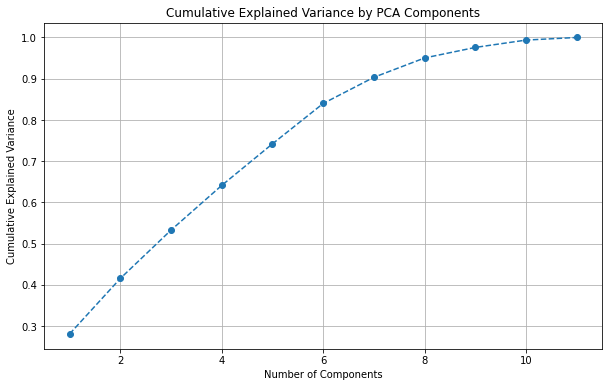

In [5]:
# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [6]:
# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Determine the number of components needed to explain ~90% of the variance
optimal_pca_components = next(i for i, cumulative_variance in enumerate(cumulative_variance) if cumulative_variance >= 0.90) + 1

print(f"Optimal number of PCA components: {optimal_pca_components}")

Optimal number of PCA components: 7


# Optimizing Number of Clusters

- We will use elbow method and silhouette score to find the optimal number of clusters for k-means clustering and hierarchical clustering

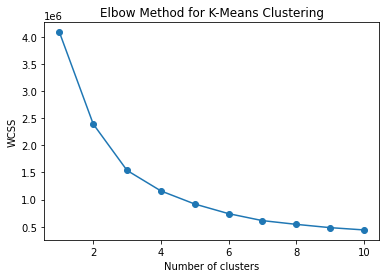

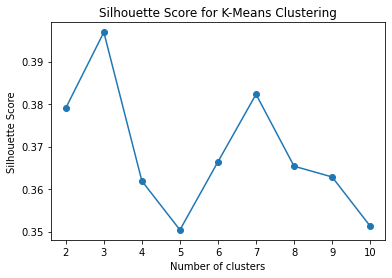

In [7]:
# Function to plot the elbow method
def plot_elbow_method(data):
    wcss = []
    for n in range(1, 11):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for K-Means Clustering')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Function to calculate silhouette score
def calculate_silhouette_score(data):
    silhouette_scores = []
    for n in range(2, 11):
        kmeans = KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Score for K-Means Clustering')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

# Plot the elbow method for t-SNE results
plot_elbow_method(df_tsne)

# Calculate and plot silhouette score for t-SNE results
calculate_silhouette_score(df_tsne)

**Optimal # of clusters: 3**

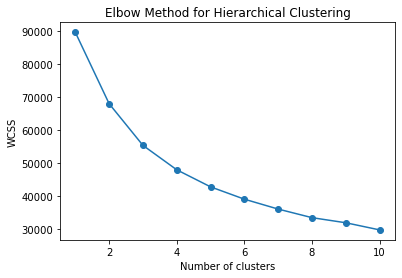

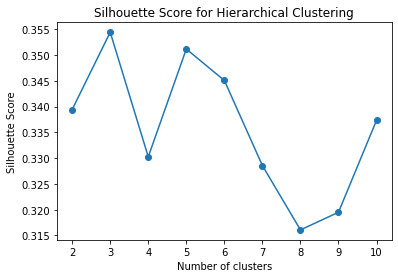

In [8]:
# Function to plot the elbow method for Hierarchical Clustering
def plot_elbow_method_hierarchical(data):
    linkage_matrix = linkage(data, method='ward')
    wcss = []
    for n in range(1, 11):
        cluster_labels = fcluster(linkage_matrix, n, criterion='maxclust')
        centroids = np.array([data[cluster_labels == i].mean(axis=0) for i in range(1, n + 1)])
        wcss.append(sum(np.min(cdist(data, centroids, 'euclidean'), axis=1)))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Hierarchical Clustering')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Function to calculate silhouette score for Hierarchical Clustering
def calculate_silhouette_score_hierarchical(data):
    linkage_matrix = linkage(data, method='ward')
    silhouette_scores = []
    for n in range(2, 11):
        cluster_labels = fcluster(linkage_matrix, n, criterion='maxclust')
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Score for Hierarchical Clustering')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

# Assuming df_tsne is your transformed data after applying t-SNE
# Plot the elbow method for hierarchical clustering
plot_elbow_method_hierarchical(df_tsne)

# Calculate and plot silhouette score for hierarchical clustering
calculate_silhouette_score_hierarchical(df_tsne)

In [9]:
optimal_num_clusters = 3

**Optimal # of clusters: 3**

# Optimizing Perplexity for t-SNE

In [10]:
# Define function to perform clustering and evaluation
def evaluate_clustering(X, method='kmeans', n_clusters=optimal_num_clusters):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    else:
        model = AgglomerativeClustering(n_clusters=optimal_num_clusters)
    
    labels = model.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    
    return silhouette, davies_bouldin

In [11]:
# Define a range of perplexity values to test
perplexity_range = [5, 10, 20, 30, 40, 50, 60]
results = []

for perplexity in perplexity_range:
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Evaluate clustering for K-Means with optimal clusters
    tsne_kmeans_silhouette, tsne_kmeans_davies_bouldin = evaluate_clustering(X_tsne, method='kmeans', n_clusters=optimal_num_clusters)
    
    # Evaluate clustering for Hierarchical Clustering with optimal clusters
    tsne_agg_silhouette, tsne_agg_davies_bouldin = evaluate_clustering(X_tsne, method='hierarchical', n_clusters=optimal_num_clusters)
    
    results.append({
        'Perplexity': perplexity,
        't-SNE K-Means Silhouette Score': tsne_kmeans_silhouette,
        't-SNE K-Means Davies-Bouldin Index': tsne_kmeans_davies_bouldin,
        't-SNE Agg. Clustering Silhouette Score': tsne_agg_silhouette,
        't-SNE Agg. Clustering Davies-Bouldin Index': tsne_agg_davies_bouldin
    })

results_df = pd.DataFrame(results)
print(results_df)

   Perplexity  t-SNE K-Means Silhouette Score  \
0           5                        0.366659   
1          10                        0.388431   
2          20                        0.378102   
3          30                        0.396913   
4          40                        0.390205   
5          50                        0.411402   
6          60                        0.411159   

   t-SNE K-Means Davies-Bouldin Index  t-SNE Agg. Clustering Silhouette Score  \
0                            0.876562                                0.325872   
1                            0.859256                                0.349660   
2                            0.870670                                0.322383   
3                            0.847746                                0.354410   
4                            0.898618                                0.353778   
5                            0.867596                                0.347590   
6                            0.876677   

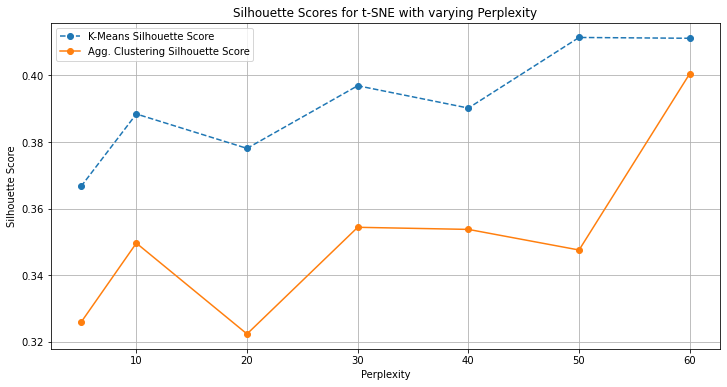

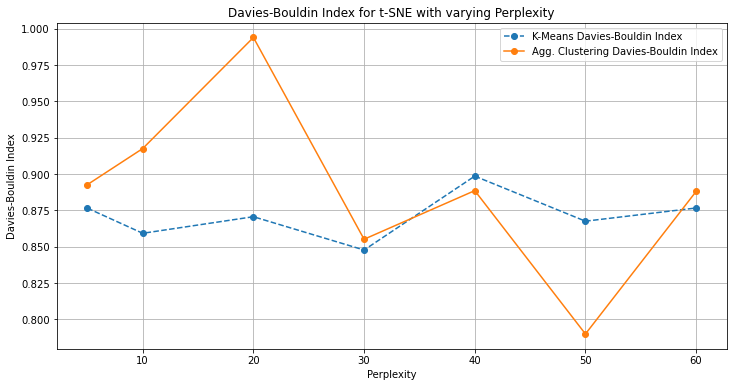

In [12]:
# Plot Silhouette Scores for K-Means and Hierarchical Clustering
plt.figure(figsize=(12, 6))
plt.plot(results_df['Perplexity'], results_df['t-SNE K-Means Silhouette Score'], marker='o', linestyle='--', label='K-Means Silhouette Score')
plt.plot(results_df['Perplexity'], results_df['t-SNE Agg. Clustering Silhouette Score'], marker='o', linestyle='-', label='Agg. Clustering Silhouette Score')
plt.title('Silhouette Scores for t-SNE with varying Perplexity')
plt.xlabel('Perplexity')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Davies-Bouldin Index for K-Means and Hierarchical Clustering
plt.figure(figsize=(12, 6))
plt.plot(results_df['Perplexity'], results_df['t-SNE K-Means Davies-Bouldin Index'], marker='o', linestyle='--', label='K-Means Davies-Bouldin Index')
plt.plot(results_df['Perplexity'], results_df['t-SNE Agg. Clustering Davies-Bouldin Index'], marker='o', linestyle='-', label='Agg. Clustering Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for t-SNE with varying Perplexity')
plt.xlabel('Perplexity')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Determine the optimal perplexity based on Silhouette Score
optimal_perplexity_kmeans = results_df.loc[results_df['t-SNE K-Means Silhouette Score'].idxmax(), 'Perplexity']
optimal_perplexity_agg = results_df.loc[results_df['t-SNE Agg. Clustering Silhouette Score'].idxmax(), 'Perplexity']

print(f"Optimal perplexity for K-Means: {optimal_perplexity_kmeans}")
print(f"Optimal perplexity for Agglomerative Clustering: {optimal_perplexity_agg}")

Optimal perplexity for K-Means: 50
Optimal perplexity for Agglomerative Clustering: 60


# Clustering Performance

In [14]:
# Apply PCA with the optimal number of components
pca = PCA(n_components=optimal_pca_components)
X_pca = pca.fit_transform(X_scaled)

# Apply t-SNE with the optimal perplexity (k-Means)
tsne_k = TSNE(n_components=2, perplexity=optimal_perplexity_kmeans, random_state=42)
X_tsne_k_optimal = tsne_k.fit_transform(X_scaled)
 
# Apply t-SNE with the optimal perplexity (Hierarchical)
tsne_agg = TSNE(n_components=2, perplexity=optimal_perplexity_agg, random_state=42)
X_tsne_agg_optimal = tsne_agg.fit_transform(X_scaled)

## PCA vs. t-SNE

In [15]:
# Apply clustering on PCA-reduced data
pca_kmeans_silhouette, pca_kmeans_davies_bouldin = evaluate_clustering(X_pca, method='kmeans', n_clusters=4)
pca_agg_silhouette, pca_agg_davies_bouldin = evaluate_clustering(X_pca, method='hierarchical', n_clusters=4)

# Apply clustering on t-SNE-reduced data
tsne_kmeans_silhouette, tsne_kmeans_davies_bouldin = evaluate_clustering(X_tsne_k_optimal, method='kmeans', n_clusters=4)
tsne_agg_silhouette, tsne_agg_davies_bouldin = evaluate_clustering(X_tsne_agg_optimal, method='hierarchical', n_clusters=4)

In [16]:
# Print results
evaluation_results = pd.DataFrame({
    'Method': ['PCA', 't-SNE'],
    'K-Means Silhouette Score': [pca_kmeans_silhouette, tsne_kmeans_silhouette],
    'K-Means Davies-Bouldin Index': [pca_kmeans_davies_bouldin, tsne_kmeans_davies_bouldin],
    'Agg. Clustering Silhouette Score': [pca_agg_silhouette, tsne_agg_silhouette],
    'Agg. Clustering Davies-Bouldin Index': [pca_agg_davies_bouldin, tsne_agg_davies_bouldin]
})

print(evaluation_results)

  Method  K-Means Silhouette Score  K-Means Davies-Bouldin Index  \
0    PCA                  0.163599                      1.938777   
1  t-SNE                  0.385450                      0.820739   

   Agg. Clustering Silhouette Score  Agg. Clustering Davies-Bouldin Index  
0                          0.226291                              1.545270  
1                          0.400531                              0.888063  


## PCA + t-SNE

In [17]:
# Apply K-Means clustering
pca_tsne_kmeans_silhouette, pca_tsne_kmeans_davies_bouldin = evaluate_clustering(X_tsne_k_optimal, method='kmeans', n_clusters=4)

# Apply Agglomerative Clustering
pca_tsne_agg_silhouette, pca_tsne_agg_davies_bouldin = evaluate_clustering(X_tsne_agg_optimal, method='hierarchical', n_clusters=4)

print(f"K-Means Silhouette Score (PCA + t-SNE): {pca_tsne_kmeans_silhouette}")
print(f"K-Means Davies-Bouldin Index (PCA + t-SNE): {pca_tsne_kmeans_davies_bouldin}")
print(f"Agg. Clustering Silhouette Score (PCA + t-SNE): {pca_tsne_agg_silhouette}")
print(f"Agg. Clustering Davies-Bouldin Index (PCA + t-SNE): {pca_tsne_agg_davies_bouldin}")

K-Means Silhouette Score (PCA + t-SNE): 0.38544976711273193
K-Means Davies-Bouldin Index (PCA + t-SNE): 0.8207391906038976
Agg. Clustering Silhouette Score (PCA + t-SNE): 0.4005306363105774
Agg. Clustering Davies-Bouldin Index (PCA + t-SNE): 0.888063208218271


# Dataframe for Comparison

In [18]:
# Define the results
results = {
    'Method': ['PCA with K-Means', 't-SNE with K-Means', 'PCA + t-SNE with K-Means', 
               'PCA with Hierarchical Clustering', 't-SNE with Hierarchical Clustering', 'PCA + t-SNE with Hierarchical Clustering'],
    'Silhouette Score': [pca_kmeans_silhouette, tsne_kmeans_silhouette, pca_tsne_kmeans_silhouette, 
                         pca_agg_silhouette, tsne_agg_silhouette, pca_tsne_agg_silhouette],
    'Davies-Bouldin Index': [pca_kmeans_davies_bouldin, tsne_kmeans_davies_bouldin, pca_tsne_kmeans_davies_bouldin, 
                             pca_agg_davies_bouldin, tsne_agg_davies_bouldin, pca_tsne_agg_davies_bouldin]
}

# Create DataFrame
evaluation_results = pd.DataFrame(results)
evaluation_results

,Method,Silhouette Score,Davies-Bouldin Index
0,PCA with K-Means,0.163599,1.938777
1,t-SNE with K-Means,0.385450,0.820739
2,PCA + t-SNE with K-Means,0.385450,0.820739
3,PCA with Hierarchical Clustering,0.226291,1.545270
4,t-SNE with Hierarchical Clustering,0.400531,0.888063
5,PCA + t-SNE with Hierarchical Clustering,0.400531,0.888063


# Visualizations

In [25]:
def plot_clusters(X_pca, X_tsne, X_pca_tsne, pca_kmeans_labels, tsne_kmeans_labels, pca_agg_labels, tsne_agg_labels, pca_tsne_kmeans_labels, pca_tsne_agg_labels):
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # Plot PCA with K-Means
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=pca_kmeans_labels, palette='viridis', ax=axes[0, 0])
    axes[0, 0].set_title('PCA with K-Means (3 Clusters)')
    axes[0, 0].set_xlabel('Principal Component 1')
    axes[0, 0].set_ylabel('Principal Component 2')
    
    # Plot t-SNE with K-Means
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=tsne_kmeans_labels, palette='viridis', ax=axes[0, 1])
    axes[0, 1].set_title('t-SNE with K-Means (3 Clusters)')
    axes[0, 1].set_xlabel('t-SNE Component 1')
    axes[0, 1].set_ylabel('t-SNE Component 2')
    
    # Plot PCA with Hierarchical Clustering
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=pca_agg_labels, palette='viridis', ax=axes[1, 0])
    axes[1, 0].set_title('PCA with Hierarchical Clustering (3 Clusters)')
    axes[1, 0].set_xlabel('Principal Component 1')
    axes[1, 0].set_ylabel('Principal Component 2')
    
    # Plot t-SNE with Hierarchical Clustering
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=tsne_agg_labels, palette='viridis', ax=axes[1, 1])
    axes[1, 1].set_title('t-SNE with Hierarchical Clustering (3 Clusters)')
    axes[1, 1].set_xlabel('t-SNE Component 1')
    axes[1, 1].set_ylabel('t-SNE Component 2')

    # Plot PCA + t-SNE with K-Means
    sns.scatterplot(x=X_pca_tsne[:, 0], y=X_pca_tsne[:, 1], hue=pca_tsne_kmeans_labels, palette='viridis', ax=axes[2, 0])
    axes[2, 0].set_title('PCA + t-SNE with K-Means (3 Clusters)')
    axes[2, 0].set_xlabel('t-SNE Component 1')
    axes[2, 0].set_ylabel('t-SNE Component 2')

    # Plot PCA + t-SNE with Hierarchical Clustering
    sns.scatterplot(x=X_pca_tsne[:, 0], y=X_pca_tsne[:, 1], hue=pca_tsne_agg_labels, palette='viridis', ax=axes[2, 1])
    axes[2, 1].set_title('PCA + t-SNE with Hierarchical Clustering (3 Clusters)')
    axes[2, 1].set_xlabel('t-SNE Component 1')
    axes[2, 1].set_ylabel('t-SNE Component 2')
    
    plt.tight_layout()
    plt.show()

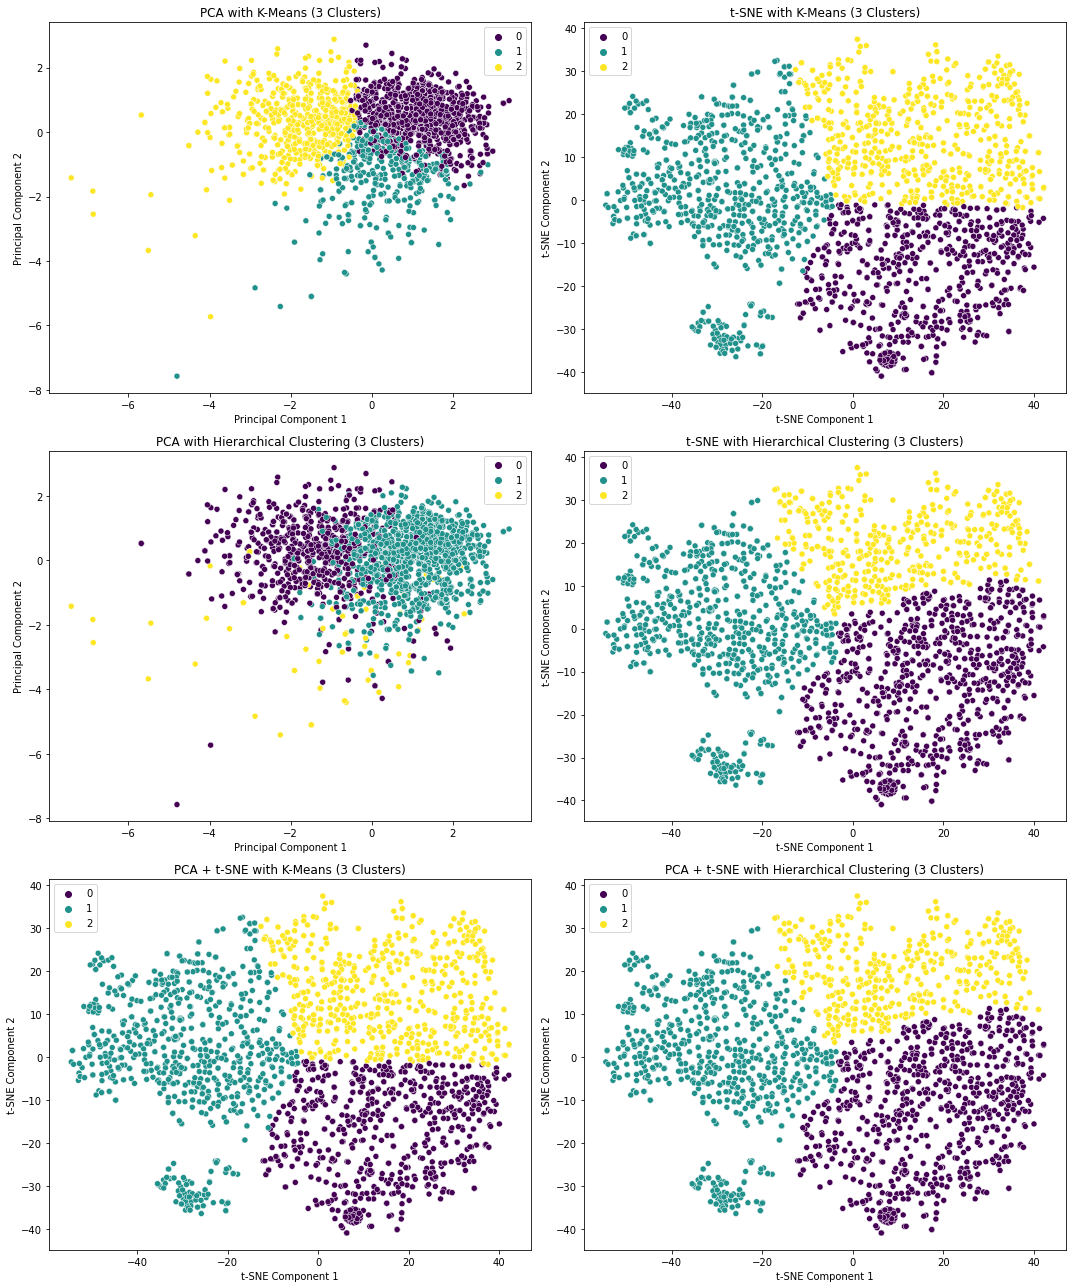

In [28]:
# PCA-reduced data
pca_kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
pca_kmeans_labels = pca_kmeans.fit_predict(X_pca)

pca_agg = AgglomerativeClustering(n_clusters=optimal_num_clusters)
pca_agg_labels = pca_agg.fit_predict(X_pca)

# t-SNE-reduced data
tsne_kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
tsne_kmeans_labels = pca_tsne_kmeans.fit_predict(X_tsne)

tsne_agg = AgglomerativeClustering(n_clusters=optimal_num_clusters)
tsne_agg_labels = tsne_agg.fit_predict(X_tsne_agg_optimal)

# PCA + t-SNE reduced data
pca_tsne_kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
pca_tsne_kmeans_labels = pca_tsne_kmeans.fit_predict(X_tsne)

pca_tsne_agg = AgglomerativeClustering(n_clusters=optimal_num_clusters)
pca_tsne_agg_labels = pca_tsne_agg.fit_predict(X_tsne)

# Plot the clusters
plot_clusters(X_pca, X_tsne, X_tsne, pca_kmeans_labels, tsne_kmeans_labels, pca_agg_labels, tsne_agg_labels, pca_tsne_kmeans_labels, pca_tsne_agg_labels)